# PHAS0030 Assessment W4 example solution (part 1)

Here I give an example solution to the first part of the W4 assessment (which forms part of the mini-project). We are solving for the orbital motion of a light body about a massive one (which we will fix for simplicity).  The basic physics is relatively straightforward, and the major problem is array indexing.  The general approach shown here should generalise to the velocity Verlet solver.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Define function for force

We create a function to calculate the gravitational force on a body $m_1$ at $\mathbf{r}_1$ from a mass $m_2$ at $\mathbf{r}_2$.

In [2]:
def force(r1,r2,m1,m2):
    """Calculate gravitational force on mass m1 at position r1 from mass m2 at position r2
    Inputs: 
    r1, r2   Positions (N dimensional Numpy arrays)
    m1, m2   Masses
    
    Depends on G, gravitational constant, defined externally
    
    Output:
    f_on_m1  Force on mass m1 (Numpy array, same dimensions as r1)
    """
    # Displacement vector
    r_12 = r2 - r1
    # Magnitude
    r_12_mag = np.sqrt(np.dot(r_12,r_12))
    # Force
    f_on_m1 = G*m1*m2*r_12/(r_12_mag**3)
    return f_on_m1

## Basic test: small and large mass bodies in orbit

We will consider a small mass body orbiting a large mass body; to a first approximation the large mass body will remain fixed, and we place it at the origin.  We will set up an appropriate force function, and test the accuracy of Euler's approach.

The initial velocity for the small body is found by solving:

$$
m_1v_1^2/r_1 = Gm_1m_2/r_{12}^2
$$

which simplifies to $v_1 = \sqrt{Gm_2r_1/r_{12}^2}$ (this is a general solution for two bodies).  We have defined $r_1 = 1$, and place the second body at the origin, which in this case gives $v_1 = 1$ and the direction should be orthogonal to $\mathbf{r}_1$.

### A note on arrays and storage

Notice the arrays that we are defining for the positions and velocities: they are two component arrays, with the first index (the row) giving the time step, and the second index (the column) the position component (x or y).  In this case `r1[n]` gives the two position components for timestep `n`, while `r1[:,i]` gives component `i` for all timesteps. (For a 3D problem, we would still have two components, and we would set `Ndim = 3`.)

You could choose to combine all particle positions into one array, which would then need to be a *three* component array, where the components would be timestep, particle number and position component (something like `r = np.zeros((Nsteps,Nparts,Ndim))` would define the storage).  In that case, you would replace `r1[n]` with `r[n,0]` for the position of the first body at time step `n`.  This approach is perhaps more compact (and is necessary if you want to do something like Runge-Kutta for more than one moving particle) but potentially more confusing as well.  For these simulations you can manage very well with separate arrays if you want.

In [3]:
# Define parameters with assumed units
Ndim = 2
Nsteps = 100000
dt = 0.001
G = 1 # Appropriate units
# m1 small, m2 large (at origin)
m1 = 0.0001
m2 = 1
# Storage
r1 = np.zeros((Nsteps,Ndim))
r2 = np.zeros((Nsteps,Ndim))
v1 = np.zeros((Nsteps,Ndim))
v2 = np.zeros((Nsteps,Ndim))
ke = np.zeros(Nsteps)
pe = np.zeros(Nsteps)
# Initial conditions
r1[0,:] = np.array((1.0,0.0))
v1[0,:] = np.array((0.0,1.0))
step = 0
ke[step] = 0.5*m1*np.dot(v1[step],v1[step]) + 0.5*m2*np.dot(v2[step],v2[step])
pe[step] = -G*m1*m2/(np.sqrt(np.dot(r1[step] - r2[step],r1[step]-r2[step])))

### Simple integrator: Euler

We'll test Euler first for this system.  We know it's not reliable, but it shouldn't do too badly.  The basic update step for any function $y(t)$ where we have $dy/dt = f(y,t)$ is $y(t+dt) = y(t) + dt*f(y,t)$.  We are using arrays to represent values of the quantities we want at different times, so we write `y[i+1] = y[i] + dt*dydt` where `dydt` represents the gradient ($f(y,t)$ in the equation above), and could be dependent on `y[i]` and possibly `i*dt` (the time) or could be an array itself, as seen in the update step for `r[i]`.

In [4]:
for i in range(Nsteps-1):
    # Find force on mass 1
    f1 = force(r1[i],r2[i],m1,m2)
    # Update r using v = dr/dt
    r1[i+1] = r1[i] + dt*v1[i]
    # We're not updating r2, but this line shows what it would look like
    #r2[i+1] = r2[i] + dt*v2[i]
    #
    # Note that for velocity Verlet we'd need to evaluate the new force given 
    # the new positions here, before updating the velocities
    #
    # Update v using f/m = a = dv/dt
    v1[i+1] = v1[i] + dt*f1/m1
    # As with r2, we're not updating v2, but this line shows what it would look like
    #v2[i+1] = v2[i] + dt*f2/m2
    # Kinetic energy
    ke[i+1] = 0.5*m1*np.dot(v1[i+1],v1[i+1]) + 0.5*m2*np.dot(v2[i+1],v2[i+1])
    # Calculate r12 to find potential energy
    r12 = r1[i+1] - r2[i+1]
    pe[i+1] = -G*m1*m2/np.sqrt(np.dot(r12,r12))

Let's plot the orbit in real space (plotting x against y).  This should form a perfect circle if the orbit is stable (and the method is conservative).

Text(0, 0.5, 'y')

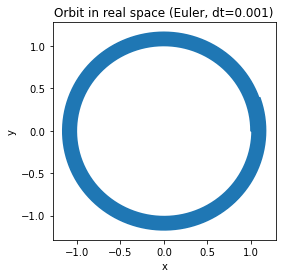

In [5]:
fig = plt.figure(figsize=(4,4))
plt.plot(r1[:,0],r1[:,1])
plt.plot(r2[:,0],r2[:,1])
plt.title(f'Orbit in real space (Euler, dt={dt})')
plt.xlabel('x')
plt.ylabel('y')

Clearly this isn't stable: the orbit changes over time.  Let's plot the components against time to see how this develops.

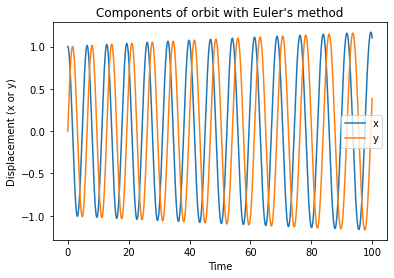

In [6]:
time = np.linspace(0,Nsteps*dt,Nsteps)
plt.plot(time,r1[:,0],label='x')
plt.plot(time,r1[:,1],label='y')
plt.xlabel("Time")
plt.ylabel("Displacement (x or y)")
plt.title("Components of orbit with Euler's method")
plt.legend()

We can see that the radius is increasing with time (this is easier to see on this plot than on the previous one, where it's not clear where we start).  It shouldn't be surprising: we know that Euler's method is poor at conservation.

Let's check the energy conservation next.

Text(0, 0.5, 'Total Energy')

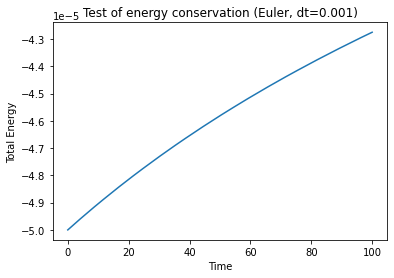

In [7]:
plt.plot(time,ke+pe)
plt.title(f'Test of energy conservation (Euler, dt={dt})')
plt.xlabel('Time')
plt.ylabel('Total Energy')

There is clearly an energy drift over time: it's not very large, but it is consistent and is another way of seeing that the orbit is changing.

Angular momentum is defined as $\mathbf{L} = m\mathbf{v} \times \mathbf{r}$ which we could find using `np.cross` if we had 3D vectors, but we know that this system is confined to a plane, and have only worried about two dimensions, so we'll evaluate it as $L = m(r_xv_y - r_yv_x)$.

Text(0.5, 1.0, 'Conservation of angular momentum (Euler, dt=0.001)')

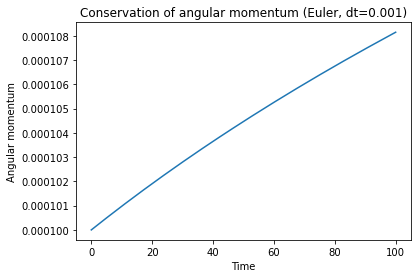

In [8]:
L1z = m1*(r1[:,0]*v1[:,1] - r1[:,1]*v1[:,0])
plt.plot(time,L1z)
plt.xlabel('Time')
plt.ylabel('Angular momentum')
plt.title(f'Conservation of angular momentum (Euler, dt={dt})')

We see that the angular momentum also drifts, in clear violation of conservation laws.  Clearly the Euler method is not accurate (though it does improve with a smaller timestep; if the number of steps is fixed, this is at least in part because the total time is shorter).  A better method is needed (we choose the velocity Verlet method).